In [63]:
##import packages##
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import glob

In [64]:
#define path
path=r"/Users/valeriyamalenko/Desktop/trading/trading/momentum/data/mecklai-finance/"

#list paths to usd-term files
files=glob.glob(path +"/*-usd.csv")

#open the first file
tb=pd.read_csv(files[0])

#append all other files in the directory to the first file
for i in files[1:]:
    tb1=pd.read_csv(i, header=0)
    tb=tb.append(tb1)
    
tb=tb[['Currency', 'Date', 'SpotDate', 'SpotRate', 'col1']]
tb=tb.drop_duplicates()
tb=tb.reset_index()
tb.drop('index', inplace=True, axis='columns')

#transorming pairs to be in per dollar terms
tb.SpotRate=1/tb.SpotRate
tb.col1=1/tb.col1

a=tb.Currency.str.split("/")
tb["Currency"]=a.str[1]+"/"+a.str[0]

In [65]:
#list paths to all usd-base files
files=glob.glob(path +"/usd-*.csv")

#open the first file
tb2=pd.read_csv(files[0])

#append all other files in the directory to the first file
for i in files[1:]:
    tb3=pd.read_csv(i, header=0)
    tb2=tb2.append(tb3)
    
tb2=tb2[['Currency', 'Date', 'SpotDate', 'SpotRate', 'col1']]
tb2=tb2.drop_duplicates()
tb2=tb2.reset_index()
tb2.drop('index', inplace=True, axis='columns')

In [66]:
#adding usd-term and usd-base dfs
frames=[tb,tb2]
df=pd.concat(frames)

In [67]:
##cleaning and transforming the data##

#convert date to datetime
df.Date=pd.to_datetime(df.Date)

#drop duplicates
ccy_l=df['Currency'].unique().tolist()
i=ccy_l[0]
df1=df[df['Currency']==i]
df1=df1.drop_duplicates(['Date'])

for i in ccy_l[1:]:
    df2=df[df['Currency']==i]
    df2=df2.drop_duplicates(['Date'])
    df1=df1.append(df2)
df=df1

#set date to be the index
df=df.set_index('Date')

#rename the column
df.rename(columns={'col1': 'fwd1m'}, inplace=True)

#delete missing data
df = df.loc[df["SpotRate"]!=0]
df = df.loc[df["fwd1m"]!=0]

#generate new cols for logs of spot and fwd rates
df['logSpotRate']=np.log(df.SpotRate)
df['logfwd1m']=np.log(df.fwd1m)

#select last day of the month for each month
df=df.loc[df.reset_index().groupby(df.index.to_period('M'))['Date'].max()]

#exclude data for 2019
dt = datetime.datetime(2019, 1, 1)
df=df[df.index < np.datetime64(dt)]

#checking the length (21*12*8 = 2016)
len(df)

2016

In [68]:
ccy_n=len(ccy_l)

#take a ccy data set
df1=df.loc[df['Currency']==ccy_l[0]]

#Below is included to suppress the warning
pd.options.mode.chained_assignment = None

#shift the fwd rate down
df1['shiftlogfwd1m']=df1.logfwd1m.shift(1)

#calculate return
df1['Returns']=df1['shiftlogfwd1m']-df1['logSpotRate']

#repeat this for all ccies
for i in ccy_l[1:]:
    tb=df.loc[df['Currency']==i]
    tb['shiftlogfwd1m']=tb.logfwd1m.shift(1)
    tb['Returns']=tb['shiftlogfwd1m']-tb['logSpotRate']
    
    #append all ccy dfs to form one df
    df1=df1.append(tb)

#generating final dataset
data=df1[['Currency', 'SpotDate', 'Returns']]
data=data.reset_index()

In [69]:
##visualising the data##

import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='pearl')

#Close down warnings
plt.rcParams.update({'figure.max_open_warning': 0})

#plot data
#data.groupby('Currency').plot(x='Date', y='Returns');

In [70]:
#let's pivot the data such that we can see what each graph/line represents
pivot1=data.pivot(index='Date', columns='Currency', values='Returns')

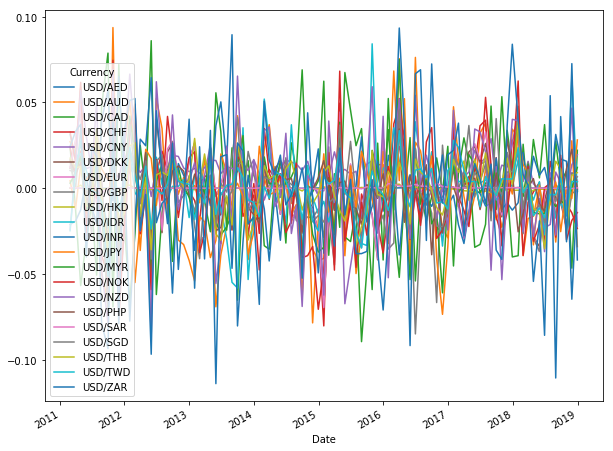

In [72]:
#let's also plot all currencies on one graph
pivot1.plot(figsize=(10,8));
#this is much better but the picture is too crowded
#from this we can see that some ccy's returns are more volatile than others
#returns are random and seem to move around zero

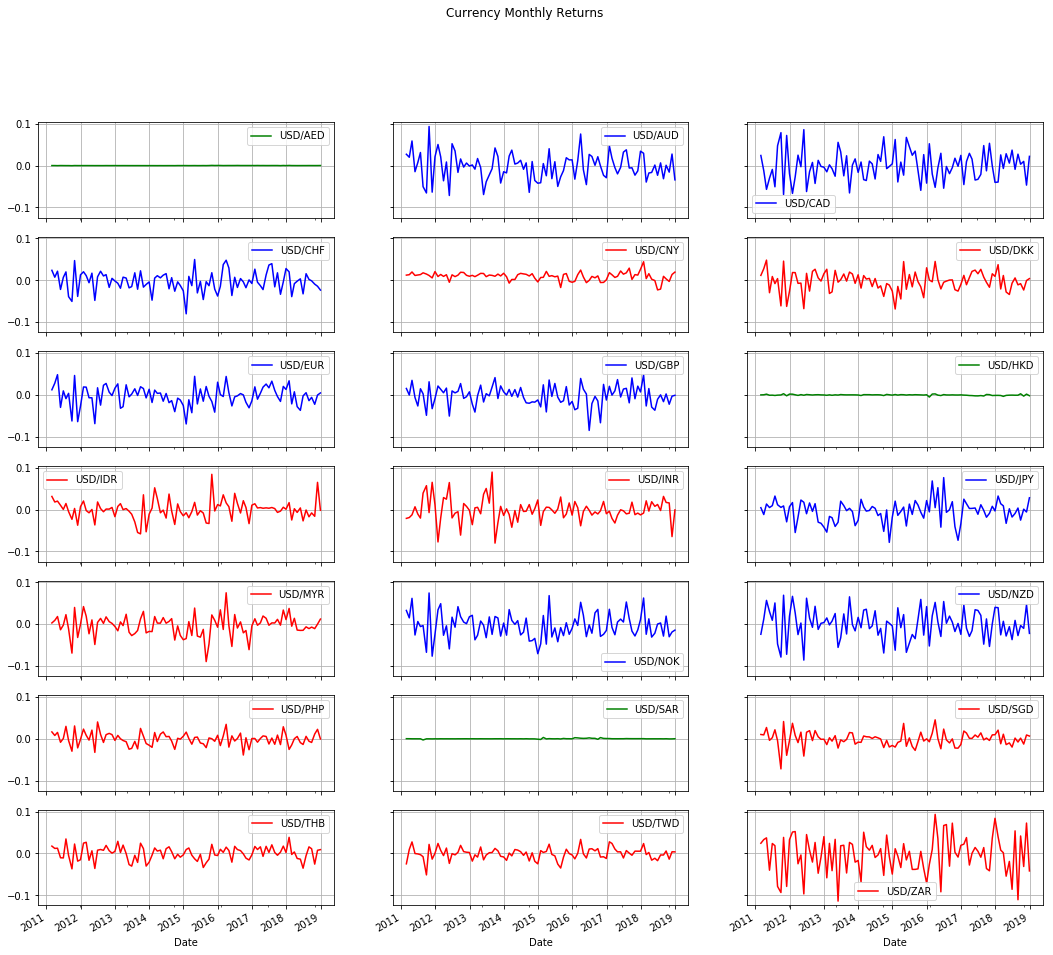

In [73]:
#let's make this plot less crowded and split currencies onto different axes
pivot1.plot(kind='line', subplots=True, grid=True, title="Currency Monthly Returns",
         sharex=True, sharey=True, legend=True, figsize=(18, 16), layout=(7,3),
        style=['g', 'b', 'b', 
               'b', 'r', 'r', 
               'b', 'b', 'g', 
               'r', 'r', 'b',
               'r', 'b', 'b', 
               'r', 'g', 'r',
               'r', 'r', 'r']);
#in blue are currencies that are in G9
#in green are currencies whose exchange rate is fixed to one degree or another
#usdzar stands out as a particularly volative pair throughout the years

In [85]:
#now, let's look at currency cumulative returns
#generate a cumulative returns column
#pivot1_cuml=pivot1.apply(lambda x: (x+1).prod() - 1)
pivot1_cuml=(1+pivot1).cumprod()

In [81]:
pivot1_cuml

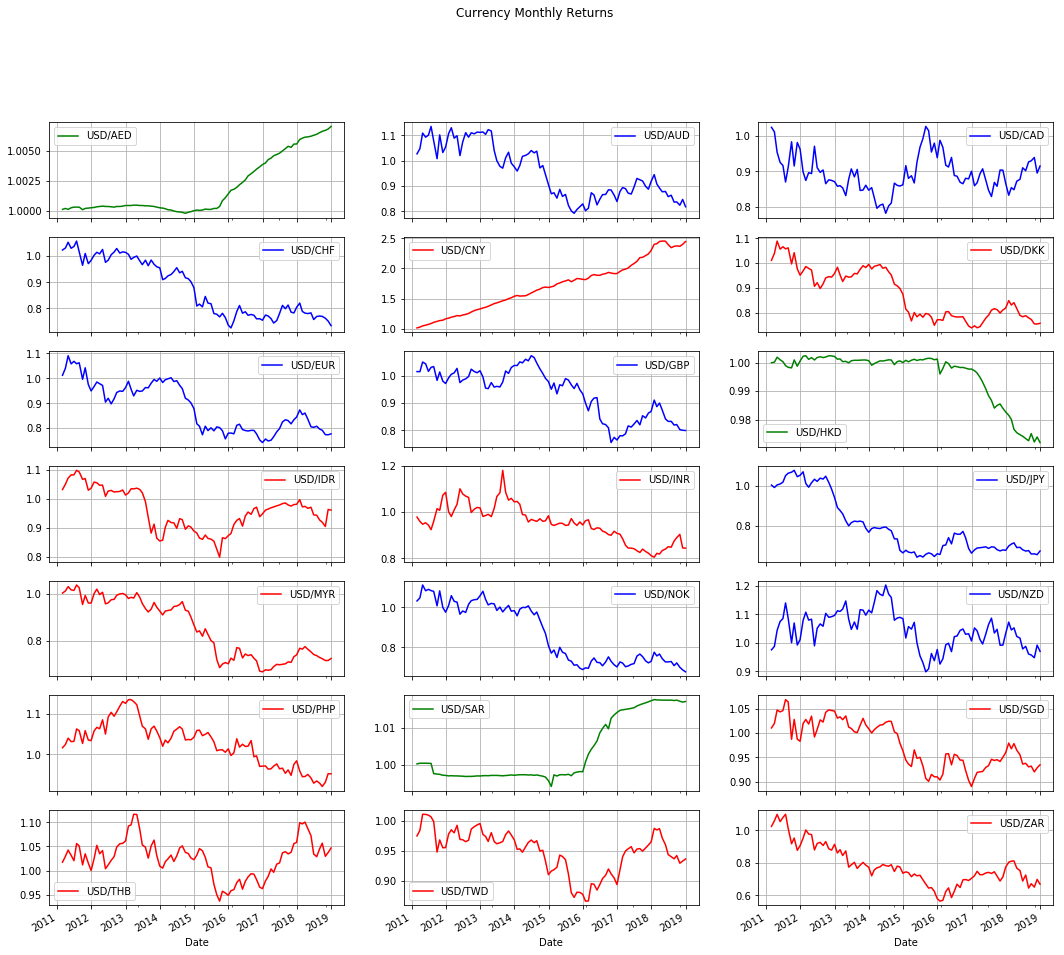

In [84]:
pivot1_cuml.plot(kind='line', subplots=True, grid=True, title="Currency Monthly Returns",
         sharex=True, sharey=False, legend=True, figsize=(18, 16), layout=(7,3),
        style=['g', 'b', 'b', 
               'b', 'r', 'r', 
               'b', 'b', 'g', 
               'r', 'r', 'b',
               'r', 'b', 'b', 
               'r', 'g', 'r',
               'r', 'r', 'r']);

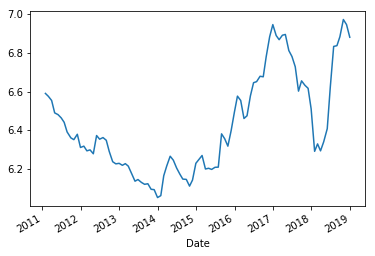

In [95]:
df_1=df.reset_index().pivot(index='Date', columns='Currency', values='SpotRate')
df_1['USD/CNY'].plot()

In [101]:
(df_1['USD/CNY'][-1]/df_1['USD/CNY'][0])-1

0.04407525413442559